In [6]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
from scipy.stats.mstats import gmean

In [7]:
# get input paths
test_set = "miplib3"
instance_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

## Check run failures

In [8]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "farkas": [],
    "prlp is primal infeasible": [],  # put outstanding bugs below here
    "must have primalbound > root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "warning": []
}

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# series that didn't run
no_go = []

# counts
count_series = 0
count_instances = 0

# iterate over all expected runs
for instance in os.listdir(instance_fldr):
    if not os.path.isdir(os.path.join(instance_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(instance_fldr, instance)):
        if not os.path.isdir(os.path.join(instance_fldr, instance, perturbation)):
            continue
        for terms in [4, 16, 64]:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(instance_fldr, instance, perturbation)
                count_instances += len([f for f in os.listdir(series_fldr) if
                                        f.endswith(".mps")])

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    for code in err:
                        if code in text:
                            err[code].append(stem)
                            break
                    else:
                        other.append(stem)

In [9]:
# check which series didn't run
print(no_go)

[]


In [10]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

1.0

In [11]:
# out of time - rerun with more time if a lot of these
err["walltime"]

['mod011_matrix_-1_16_New',
 'qnet1_objective_1_16_New',
 'qnet1_matrix_1_16_New',
 'qnet1_matrix_0_16_New',
 'qnet1_objective_0_16_New',
 'qnet1_matrix_-1_16_New',
 'qnet1_objective_-1_16_New',
 'l152lav_rhs_0_16_New',
 'l152lav_objective_1_16_New',
 'l152lav_objective_0_16_New',
 'l152lav_rhs_-1_16_New',
 'l152lav_objective_-1_16_New',
 'cap6000_objective_1_64_New',
 'cap6000_objective_0_64_New',
 'cap6000_objective_-1_64_New',
 'harp2_matrix_0_64_New',
 'air04_objective_1_4_New',
 'air04_matrix_1_4_New',
 'air04_matrix_0_4_New',
 'air04_objective_0_4_New',
 'air04_matrix_-1_4_New',
 'air05_objective_1_64_New',
 'air05_objective_1_64_Old',
 'air05_objective_1_64_Farkas',
 'air05_matrix_1_4_New',
 'air05_matrix_1_64_New',
 'air05_matrix_1_64_Old',
 'air05_matrix_1_64_Farkas',
 'air05_matrix_0_4_New',
 'air05_matrix_0_64_New',
 'air05_matrix_0_64_Old',
 'air05_matrix_0_64_Farkas',
 'air05_objective_0_64_New',
 'air05_objective_0_64_Old',
 'air05_objective_0_64_Farkas',
 'air05_matrix_-

In [12]:
# out of memory - rerun with more memory if a lot of these
err["bad_alloc"]

['blend2_objective_1_64_Old',
 'blend2_objective_1_64_Farkas',
 'blend2_matrix_-1_64_Old',
 'blend2_matrix_-1_64_Farkas',
 'p2756_objective_1_16_Old',
 'p2756_objective_1_16_Farkas',
 'p2756_matrix_1_16_Old',
 'p2756_matrix_1_16_Farkas',
 'p2756_matrix_0_16_Old',
 'p2756_matrix_0_16_Farkas',
 'p2756_objective_0_16_Old',
 'p2756_objective_0_16_Farkas',
 'p2756_matrix_-1_16_Old',
 'p2756_matrix_-1_16_Farkas',
 'p2756_objective_-1_16_Old',
 'p2756_objective_-1_16_Farkas',
 'qnet1_matrix_0_16_Farkas',
 'qnet1_matrix_-1_16_Old',
 'qnet1_matrix_-1_16_Farkas',
 'qnet1_objective_-1_16_Farkas',
 'gesa2_o_objective_1_64_Old',
 'gesa2_o_objective_1_64_Farkas',
 'gesa2_o_matrix_0_64_Farkas',
 'gesa2_o_objective_0_64_Old',
 'gesa2_o_objective_0_64_Farkas',
 'gesa2_o_matrix_-1_64_Old',
 'gesa2_o_matrix_-1_64_Farkas',
 'gesa2_o_objective_-1_64_Old',
 'gesa2_o_objective_-1_64_Farkas',
 'lseu_objective_1_64_Old',
 'lseu_objective_1_64_Farkas',
 'lseu_matrix_0_64_Old',
 'lseu_matrix_0_64_Farkas',
 'lseu

In [13]:
# this is an issue with John's bookkeeping - not much we can do here
err["takeoffcuts"]

['mod011_matrix_0_4_New',
 'mod011_matrix_0_4_Old',
 'mod011_matrix_-1_4_Old',
 'vpm1_matrix_-1_4_Old',
 'vpm1_matrix_-1_4_Farkas',
 'vpm1_matrix_-1_16_Old',
 'vpm1_matrix_-1_64_Old',
 'rentacar_matrix_-1_4_Old',
 'pp08aCUTS_matrix_0_16_Farkas',
 'pp08aCUTS_matrix_0_64_New',
 'egout_matrix_0_4_New',
 'egout_matrix_0_4_Old',
 'egout_matrix_0_4_Farkas',
 'egout_matrix_0_16_New',
 'egout_matrix_0_16_Old',
 'egout_matrix_0_16_Farkas',
 'l152lav_matrix_1_4_New',
 'p0033_objective_1_4_New',
 'p0033_objective_1_4_Old',
 'p0033_objective_1_4_Farkas',
 'p0033_matrix_1_4_Old',
 'p0033_matrix_1_16_Old',
 'p0033_objective_-1_16_Farkas',
 'dcmulti_rhs_-1_16_New',
 'bell3a_matrix_0_4_New']

In [14]:
err["solver is dual infeasible"]

[]

In [15]:
# these are usually issues with CLP finding optimality - not much we can do here
err["solver must be optimal"]

['10teams_bound_1_4_New',
 '10teams_bound_1_4_Old',
 '10teams_bound_1_4_Farkas',
 'p2756_bound_1_4_New',
 'p2756_bound_1_4_Old',
 'p2756_bound_1_4_Farkas',
 'p2756_bound_1_16_New',
 'p2756_bound_1_16_Old',
 'p2756_bound_1_16_Farkas',
 'qnet1_o_bound_1_4_New',
 'qnet1_o_bound_1_4_Old',
 'qnet1_o_bound_1_4_Farkas',
 'qnet1_o_bound_1_16_New',
 'qnet1_o_bound_1_16_Old',
 'qnet1_o_bound_1_16_Farkas',
 'qnet1_all_1_4_New',
 'qnet1_all_1_4_Old',
 'qnet1_all_1_4_Farkas',
 'qnet1_all_1_16_New',
 'qnet1_all_1_16_Old',
 'qnet1_all_1_16_Farkas',
 'qnet1_bound_1_4_New',
 'qnet1_bound_1_4_Old',
 'qnet1_bound_1_4_Farkas',
 'qnet1_bound_1_16_New',
 'qnet1_bound_1_16_Old',
 'qnet1_bound_1_16_Farkas',
 'mod010_bound_1_4_New',
 'mod010_bound_1_4_Old',
 'mod010_bound_1_4_Farkas',
 'pp08aCUTS_objective_1_4_New',
 'pp08aCUTS_objective_1_4_Old',
 'pp08aCUTS_objective_1_4_Farkas',
 'pp08aCUTS_objective_1_16_New',
 'pp08aCUTS_objective_1_16_Old',
 'pp08aCUTS_objective_1_16_Farkas',
 'pp08aCUTS_objective_1_64_N

In [16]:
err["segmentation fault"]

['mod010_matrix_1_4_New',
 'p0201_objective_0_16_New',
 'p0201_objective_-1_16_New']

In [17]:
# these should all be from the problem being too big and hitting the time limit
# or integer solutions
# len(err["no vpcs were made from a new disjunction"]) / count_series  15%
err["no vpcs were made from a new disjunction"]

['10teams_objective_1_16_New',
 '10teams_objective_1_16_Old',
 '10teams_objective_1_16_Farkas',
 '10teams_objective_1_64_New',
 '10teams_objective_1_64_Old',
 '10teams_objective_1_64_Farkas',
 '10teams_matrix_1_16_New',
 '10teams_matrix_1_16_Old',
 '10teams_matrix_1_16_Farkas',
 '10teams_matrix_1_64_New',
 '10teams_matrix_1_64_Old',
 '10teams_matrix_1_64_Farkas',
 '10teams_matrix_0_16_New',
 '10teams_matrix_0_16_Old',
 '10teams_matrix_0_16_Farkas',
 '10teams_matrix_0_64_New',
 '10teams_matrix_0_64_Old',
 '10teams_matrix_0_64_Farkas',
 '10teams_objective_0_16_New',
 '10teams_objective_0_16_Old',
 '10teams_objective_0_16_Farkas',
 '10teams_objective_0_64_New',
 '10teams_objective_0_64_Old',
 '10teams_objective_0_64_Farkas',
 '10teams_objective_-1_16_New',
 '10teams_objective_-1_16_Old',
 '10teams_objective_-1_16_Farkas',
 '10teams_objective_-1_64_New',
 '10teams_objective_-1_64_Old',
 '10teams_objective_-1_64_Farkas',
 '10teams_bound_1_16_New',
 '10teams_bound_1_16_Old',
 '10teams_bound_

In [18]:
# this may be a bug in my code - track down if a lot
err["farkas"]

['mod011_objective_1_16_New',
 'mod011_objective_1_16_Old',
 'mod011_objective_1_16_Farkas',
 'mod011_matrix_1_16_Farkas',
 'mod011_matrix_0_16_New',
 'mod011_matrix_-1_16_Old',
 'mod011_matrix_-1_16_Farkas',
 'mod011_objective_-1_16_New',
 'vpm1_matrix_1_64_New',
 'rentacar_objective_1_4_New',
 'rentacar_matrix_0_4_New',
 'rentacar_objective_-1_4_New',
 'rout_objective_1_4_New',
 'rout_objective_1_4_Old',
 'rout_objective_1_4_Farkas',
 'rout_objective_1_16_New',
 'rout_objective_1_16_Old',
 'rout_objective_1_16_Farkas',
 'rout_matrix_1_4_New',
 'rout_matrix_1_4_Old',
 'rout_matrix_1_4_Farkas',
 'rout_matrix_1_16_New',
 'rout_matrix_1_16_Old',
 'rout_matrix_1_16_Farkas',
 'rout_matrix_0_4_New',
 'rout_matrix_0_4_Old',
 'rout_matrix_0_4_Farkas',
 'rout_matrix_0_16_New',
 'rout_matrix_0_16_Old',
 'rout_matrix_0_16_Farkas',
 'rout_objective_0_4_New',
 'rout_objective_0_4_Old',
 'rout_objective_0_4_Farkas',
 'rout_objective_0_16_New',
 'rout_objective_0_16_Old',
 'rout_objective_0_16_Farka

In [19]:
# this shouldn't be an issue - effected runs just get skipped
err["prlp is primal infeasible"]

['blend2_objective_1_4_Old',
 'blend2_objective_1_16_Old',
 'modglob_matrix_1_4_Old',
 'modglob_matrix_1_16_Old',
 'modglob_matrix_1_64_Old',
 'modglob_matrix_0_4_Old',
 'modglob_matrix_0_16_Old',
 'modglob_matrix_0_64_Old',
 'modglob_matrix_-1_4_Old',
 'modglob_matrix_-1_16_Old',
 'modglob_matrix_-1_64_Old',
 'p2756_matrix_1_4_New',
 'p2756_matrix_1_4_Old',
 'p2756_matrix_1_16_New',
 'p2756_matrix_0_4_New',
 'p2756_matrix_0_4_Old',
 'p2756_matrix_0_16_New',
 'p2756_rhs_-1_4_New',
 'p2756_rhs_-1_16_New',
 'p2756_matrix_-1_4_New',
 'p2756_matrix_-1_16_New',
 'mod011_matrix_1_4_Old',
 'qnet1_matrix_1_4_Old',
 'qnet1_matrix_0_4_Old',
 'mod010_matrix_1_4_Old',
 'mod010_matrix_-1_4_Old',
 'gesa2_o_matrix_0_4_Old',
 'gesa2_o_matrix_0_16_Old',
 'gesa2_o_matrix_0_64_Old',
 'gesa2_o_matrix_-1_4_Old',
 'gesa2_o_matrix_-1_16_Old',
 'lseu_rhs_0_4_Old',
 'lseu_rhs_0_16_Old',
 'lseu_rhs_0_64_Old',
 'lseu_rhs_1_4_Old',
 'lseu_rhs_1_16_Old',
 'lseu_matrix_1_4_Old',
 'lseu_matrix_1_16_Old',
 'lseu_matr

In [20]:
err["warning"]

['10teams_matrix_1_4_Old',
 '10teams_matrix_0_4_Old',
 '10teams_objective_-1_4_Old',
 'modglob_rhs_1_64_New',
 'modglob_matrix_1_64_New',
 'modglob_matrix_0_16_New',
 'modglob_matrix_0_64_New',
 'mod011_objective_1_4_New',
 'mod011_objective_1_4_Old',
 'mod011_matrix_1_4_New',
 'mod011_matrix_1_16_Old',
 'mod011_objective_0_4_New',
 'mod011_objective_0_4_Old',
 'mod011_objective_0_16_New',
 'mod011_matrix_-1_4_New',
 'mod011_objective_-1_4_New',
 'mod011_objective_-1_4_Old',
 'rentacar_objective_1_4_Old',
 'rentacar_objective_1_4_Farkas',
 'rentacar_matrix_0_4_Old',
 'rentacar_matrix_0_4_Farkas',
 'rentacar_objective_0_4_New',
 'rentacar_objective_0_4_Old',
 'rentacar_objective_0_4_Farkas',
 'rentacar_matrix_-1_4_New',
 'rentacar_matrix_-1_4_Farkas',
 'rentacar_objective_-1_4_Old',
 'rentacar_objective_-1_4_Farkas',
 'lseu_matrix_1_64_New',
 'lseu_matrix_0_64_New',
 'fixnet6_objective_1_64_New',
 'egout_rhs_0_16_New',
 'egout_objective_1_4_New',
 'egout_objective_1_16_New',
 'egout_obj

In [21]:
# issue was not optimizing solver before checking LP relaxation objective vs primal bound
err["must have primalbound > root lp objective"]

['cap6000_bound_0_4_None',
 'cap6000_bound_0_4_New',
 'cap6000_bound_0_4_Old',
 'cap6000_bound_0_4_Farkas',
 'cap6000_bound_0_16_None',
 'cap6000_bound_0_16_New',
 'cap6000_bound_0_16_Old',
 'cap6000_bound_0_16_Farkas',
 'cap6000_bound_0_64_None',
 'cap6000_bound_0_64_New',
 'cap6000_bound_0_64_Old',
 'cap6000_bound_0_64_Farkas',
 'cap6000_bound_1_4_None',
 'cap6000_bound_1_4_New',
 'cap6000_bound_1_4_Old',
 'cap6000_bound_1_4_Farkas',
 'cap6000_bound_1_16_None',
 'cap6000_bound_1_16_New',
 'cap6000_bound_1_16_Old',
 'cap6000_bound_1_16_Farkas',
 'cap6000_bound_1_64_None',
 'cap6000_bound_1_64_New',
 'cap6000_bound_1_64_Old',
 'cap6000_bound_1_64_Farkas',
 'harp2_bound_1_4_None',
 'harp2_bound_1_4_New',
 'harp2_bound_1_4_Old',
 'harp2_bound_1_4_Farkas',
 'harp2_bound_1_16_None',
 'harp2_bound_1_16_New',
 'harp2_bound_1_16_Old',
 'harp2_bound_1_16_Farkas',
 'harp2_bound_1_64_None',
 'harp2_bound_1_64_New',
 'harp2_bound_1_64_Old',
 'harp2_bound_1_64_Farkas',
 'dcmulti_matrix_1_4_None',


In [22]:
# LP relxation objective is not going to match root node objective when warm starting 
err["objective at parent node"]

[]

In [23]:
# not enough tolerance added to bound (or we hit time limit)
# todo handle this gracefully
# len(err["failed to optimize mip"]) / count_series  10%
err["failed to optimize mip"]

['enigma_rhs_0_4_None',
 'enigma_rhs_0_4_New',
 'enigma_rhs_0_4_Old',
 'enigma_rhs_0_4_Farkas',
 'enigma_rhs_0_16_None',
 'enigma_rhs_0_16_New',
 'enigma_rhs_0_16_Old',
 'enigma_rhs_0_16_Farkas',
 'enigma_rhs_0_64_None',
 'enigma_rhs_0_64_New',
 'enigma_rhs_0_64_Old',
 'enigma_rhs_0_64_Farkas',
 'enigma_rhs_1_4_None',
 'enigma_rhs_1_4_New',
 'enigma_rhs_1_4_Old',
 'enigma_rhs_1_4_Farkas',
 'enigma_rhs_1_16_None',
 'enigma_rhs_1_16_New',
 'enigma_rhs_1_16_Old',
 'enigma_rhs_1_16_Farkas',
 'enigma_rhs_1_64_None',
 'enigma_rhs_1_64_New',
 'enigma_rhs_1_64_Old',
 'enigma_rhs_1_64_Farkas',
 'enigma_matrix_0_4_None',
 'enigma_matrix_0_4_New',
 'enigma_matrix_0_4_Old',
 'enigma_matrix_0_4_Farkas',
 'enigma_matrix_0_16_None',
 'enigma_matrix_0_16_New',
 'enigma_matrix_0_16_Old',
 'enigma_matrix_0_16_Farkas',
 'enigma_matrix_0_64_None',
 'enigma_matrix_0_64_New',
 'enigma_matrix_0_64_Old',
 'enigma_matrix_0_64_Farkas',
 'enigma_matrix_-1_4_None',
 'enigma_matrix_-1_4_New',
 'enigma_matrix_-1_4_

In [24]:
# todo: figure out why
# len(err["disjunction does not represent a full binary tree"]) / count_series  6%
err["disjunction does not represent a full binary tree"]

['blend2_matrix_1_16_New',
 'blend2_matrix_1_64_New',
 'blend2_matrix_0_16_New',
 'blend2_matrix_0_64_New',
 'blend2_matrix_-1_16_New',
 'blend2_matrix_-1_64_New',
 'bell5_rhs_0_4_New',
 'bell5_rhs_0_16_New',
 'bell5_rhs_0_64_New',
 'bell5_rhs_1_64_New',
 'bell5_matrix_1_4_New',
 'bell5_matrix_0_64_New',
 'bell5_rhs_-1_4_New',
 'bell5_rhs_-1_16_New',
 'bell5_rhs_-1_64_New',
 'bell5_matrix_-1_16_New',
 'bell5_matrix_-1_64_New',
 'p0033_rhs_0_16_New',
 'p0033_rhs_1_4_New',
 'p0033_matrix_1_4_New',
 'p0033_matrix_1_16_New',
 'p0033_matrix_0_16_New',
 'p0033_matrix_-1_16_New',
 'gesa3_rhs_-1_16_New',
 'gesa3_rhs_-1_64_New',
 'gesa2_rhs_-1_16_New',
 'gesa2_rhs_-1_64_New',
 'gesa2_matrix_-1_64_New',
 'bell3a_matrix_0_16_New',
 'bell3a_matrix_-1_16_New',
 'bell3a_matrix_-1_64_New',
 'gt2_rhs_0_16_New',
 'gt2_rhs_0_64_New',
 'gt2_rhs_1_16_New',
 'gt2_rhs_1_64_New',
 'gt2_matrix_1_16_New',
 'gt2_matrix_1_64_New',
 'gt2_matrix_0_16_New',
 'gt2_matrix_0_64_New',
 'gt2_rhs_-1_16_New',
 'gt2_rhs_-1

In [25]:
# this and next issue I think are because we run out of time creating tree leading to errors
# todo: handle gracefully 
err["nonbasic reduced cost should be"]

['arki001_objective_1_4_Old',
 'arki001_objective_1_4_Farkas',
 'arki001_objective_1_16_Old',
 'arki001_objective_1_16_Farkas',
 'arki001_matrix_0_4_New',
 'arki001_matrix_0_4_Farkas',
 'arki001_matrix_0_16_New',
 'arki001_matrix_0_16_Farkas',
 'arki001_matrix_0_64_Farkas',
 'arki001_objective_0_4_Old',
 'arki001_objective_0_4_Farkas',
 'arki001_objective_0_16_Old',
 'arki001_objective_0_16_Farkas',
 'arki001_matrix_-1_4_New',
 'arki001_matrix_-1_4_Farkas',
 'arki001_matrix_-1_16_New',
 'arki001_matrix_-1_16_Farkas',
 'arki001_objective_-1_4_Old',
 'arki001_objective_-1_4_Farkas',
 'arki001_objective_-1_16_Old',
 'arki001_objective_-1_16_Farkas',
 'mas76_matrix_1_4_New']

In [26]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
err["solver not proven optimal for node"]

[]

In [27]:
err["unable to open"]

[]

In [28]:
len(err["license"]) / count_series

0.0

In [29]:
# errors unaccounted for
other

['mod011_matrix_1_16_New',
 'rentacar_objective_1_16_New',
 'rentacar_objective_1_16_Old',
 'rentacar_objective_1_16_Farkas',
 'rentacar_matrix_0_16_New',
 'rentacar_matrix_0_16_Old',
 'rentacar_matrix_0_16_Farkas',
 'rentacar_objective_0_16_New',
 'rentacar_objective_0_16_Old',
 'rentacar_objective_0_16_Farkas',
 'rentacar_matrix_-1_16_New',
 'rentacar_matrix_-1_16_Old',
 'rentacar_matrix_-1_16_Farkas',
 'rentacar_objective_-1_16_New',
 'rentacar_objective_-1_16_Old',
 'rentacar_objective_-1_16_Farkas',
 'p0201_matrix_1_16_New',
 'p0201_matrix_0_16_New',
 'pk1_rhs_0_4_None',
 'pk1_rhs_0_16_None',
 'pk1_rhs_0_64_None',
 'pk1_rhs_1_4_None',
 'pk1_rhs_1_16_None',
 'pk1_rhs_1_64_None']

In [30]:
# proportion of series that had no critical issues
len(empty + err["warning"] + err["prlp is primal infeasible"] + err["walltime"]) / count_series

0.6564285714285715

In [31]:
# proportion of series that had no critical issues/issues we can't control
for generator in ["None", "New", "Old", "Farkas"]:
    g = [s for s in empty + err["warning"] + err["prlp is primal infeasible"] +
         err["walltime"] + err["bad_alloc"] + err["solver not proven optimal for node"] +
         err["nonbasic reduced cost should be"] + err["solver must be optimal"] +
         err["takeoffcuts"] + err["no vpcs were made from a new disjunction"]
         if s.endswith(generator)]
    print(f"{generator}: {4 * len(g) / count_series}")

None: 0.9457142857142857
New: 0.8847619047619047
Old: 0.9619047619047619
Farkas: 0.9571428571428572


In [32]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["walltime"])) / count_series

0.05976190476190476

## Read in data

In [33]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "primalBound": float,
    "rootDualBound": float
}

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = match.group(1)
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])

In [34]:
# get proportion of instances run
for generator, df in df_map.items():
    print(f"{generator}: {4 * len(df) / count_instances}")

None: 0.9612845138055222
Farkas: 0.5989395758303321
New: 0.5670268107242897
Old: 0.5290116046418567


In [35]:
gen = "Farkas" # make sure masks 3 and 9 are fixed rest should be fine
masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"],
        2: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"],
        3: df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"],
        4: df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"],
        5: df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"],
        6: df_map[gen]["primalBound"] > 1e20,
        7: 0 > df_map[gen]["vpcGenerationTime"],
        8: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"],
        9: df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"],
        10: df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"],
        11: df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"],
        12: df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20
    }

df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,nodes,iterations,maxTime,actualTerms,numCuts,mipSolver,providePrimalBound,instance,perturbation,degree


In [36]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-4 > df_map[gen]["lpBoundPostVpc"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["disjunctiveDualBound"]) | \
        (df_map[gen]["lpBoundPostVpc"] - 1e-4 > df_map[gen]["rootDualBound"]) | \
        (df_map[gen]["rootDualBound"] - 1e-4 > df_map[gen]["dualBound"]) | \
        (df_map[gen]["dualBound"] - 1e-4 > df_map[gen]["primalBound"]) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-4 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-4 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["terminationTime"] > df_map[gen]["maxTime"] + 20)
    df_map[gen] = df_map[gen][~mask]

In [37]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTime Farkas,bestSolutionTime Farkas,terminationTime Farkas,nodes Farkas,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,mipSolver Farkas,providePrimalBound Farkas
0,0,None,64,2.910894e+02,2.910894e+02,2.910894e+02,3.014050e+02,3.070000e+02,3.070000e+02,0.080333,...,20.384347,22.604347,22.608347,483,2967,300.0,65,6,CBC,1
1,1,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.971517e+02,3.070000e+02,3.070000e+02,0.001249,...,2.861909,300.117909,300.161909,68667,270074,300.0,65,6,CBC,1
2,2,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.075104e+02,3.110000e+02,3.110000e+02,0.001282,...,2.629594,37.601594,37.645594,9594,31899,300.0,65,6,CBC,1
3,3,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.075104e+02,3.110000e+02,3.110000e+02,0.001273,...,2.637288,37.537288,37.569288,9594,31899,300.0,65,6,CBC,1
4,4,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.971517e+02,3.070000e+02,3.070000e+02,0.001700,...,2.866354,300.126354,300.170354,68817,270718,300.0,65,6,CBC,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,8,None,4,3.998440e+02,3.998440e+02,3.998440e+02,7.692499e+02,1.082000e+03,1.082000e+03,0.003540,...,1.589315,27.237315,27.245315,1761,11350,300.0,4,12,CBC,1
4201,10,None,4,2.426898e+03,2.426898e+03,2.426898e+03,2.750469e+03,3.002000e+03,3.002000e+03,0.003512,...,0.898910,84.430910,84.438910,5367,35731,300.0,4,12,CBC,1
4202,0,None,64,9.591946e+07,9.591946e+07,9.591946e+07,1.068627e+08,1.069402e+08,1.069402e+08,0.066066,...,55.772912,56.076912,56.084912,14,404,300.0,64,4,CBC,1
4203,0,None,16,8.951800e+06,8.951800e+06,8.951800e+06,8.959323e+06,8.966406e+06,8.966406e+06,0.004773,...,1.408592,3.556592,3.556592,2384,3002,300.0,18,4,CBC,1


In [38]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.42066826730692275

In [39]:
def gap_closed(df, col):
    gap = (df[col] - df["lpBound None"]) / (df['primalBound None'] - df["lpBound None"])
    gap[(gap < 0) | (gap > 1)] = np.nan
    return gap

In [40]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df = df.dropna()

In [41]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"] 

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_91920/3051651982.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc None"] = df["terminationTime None"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_91920/3051651982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_91920/3051651982.py:4: SettingWithCopyWarni

In [42]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,terminationTimeSansVpc Farkas,rootDualBoundTimeSansVpc None,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement
0,0,None,64,2.910894e+02,2.910894e+02,2.910894e+02,3.014050e+02,3.070000e+02,3.070000e+02,0.080333,...,2.640,0.760333,0.412,0.412,0.416,0.740,2.228,2.224,2.224,-14.068886
1,1,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.971517e+02,3.070000e+02,3.070000e+02,0.001249,...,299.628,2.265249,2.416,2.224,2.328,287.192,275.632,284.676,297.300,-0.036982
2,2,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.075104e+02,3.110000e+02,3.110000e+02,0.001282,...,37.100,1.821282,2.200,1.964,2.084,1.700,4.900,8.460,35.016,-9.690877
3,3,None,64,2.987642e+02,2.987642e+02,2.987642e+02,3.075104e+02,3.110000e+02,3.110000e+02,0.001273,...,37.012,1.825273,2.204,1.964,2.080,1.688,4.912,8.440,34.932,-9.693529
4,4,None,64,2.834221e+02,2.834221e+02,2.834221e+02,2.971517e+02,3.070000e+02,3.070000e+02,0.001700,...,299.640,2.285700,2.412,2.220,2.336,287.012,275.624,284.744,297.304,-0.037583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4200,8,None,4,3.998440e+02,3.998440e+02,3.998440e+02,7.692499e+02,1.082000e+03,1.082000e+03,0.003540,...,27.124,1.479540,1.100,1.612,1.468,134.308,237.148,79.952,25.656,0.799353
4201,10,None,4,2.426898e+03,2.426898e+03,2.426898e+03,2.750469e+03,3.002000e+03,3.002000e+03,0.003512,...,84.320,0.855512,1.384,0.760,0.780,34.332,49.932,156.164,83.540,-1.399684
4202,0,None,64,9.591946e+07,9.591946e+07,9.591946e+07,1.068627e+08,1.069402e+08,1.069402e+08,0.066066,...,0.576,0.442066,0.264,0.264,0.264,0.316,0.316,0.312,0.312,-72.984207
4203,0,None,16,8.951800e+06,8.951800e+06,8.951800e+06,8.959323e+06,8.966406e+06,8.966406e+06,0.004773,...,2.196,0.268773,0.044,0.048,0.048,44.396,2.144,2.168,2.148,0.920371


In [43]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999)

## Make bound table

In [44]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
1,mod008,rhs,2.0,64,1,0.127044,0.116834,0.120808,0.096567,0.086278,0.582307,0.524103,0.545835,0.569623
2,mod008,rhs,2.0,64,2,0.442199,0.423585,0.425561,0.401898,0.178407,0.714804,0.691169,0.671123,0.722055
3,mod008,rhs,2.0,64,3,0.442199,0.423585,0.425561,0.401898,0.178407,0.714804,0.691169,0.671123,0.722055
4,mod008,rhs,2.0,64,4,0.127044,0.116834,0.120808,0.096567,0.086278,0.582307,0.524103,0.545835,0.569623
6,fiber,matrix,0.5,16,1,0.095842,0.049271,0.040998,0.029203,0.019235,0.954876,0.966272,0.944114,0.952857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,fixnet6,objective,1.0,4,6,0.101658,0.223184,0.050647,0.211003,0.065105,0.443973,0.434819,0.551277,0.489726
4199,fixnet6,objective,1.0,4,7,0.216379,0.145380,0.155252,0.126102,0.001871,0.684034,0.668246,0.651857,0.683963
4200,fixnet6,objective,1.0,4,8,0.001466,0.239309,0.001466,0.216391,0.000000,0.541527,0.609327,0.568109,0.541527
4201,fixnet6,objective,1.0,4,10,0.001739,0.047157,0.001739,0.047157,0.016571,0.562633,0.563326,0.573905,0.558266


In [45]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [46]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,instanceIndex
0,0.5,4,0.165661,0.089022,0.089760,0.067842,0.061441,0.694346,0.698084,0.697411,0.697407,38,633
1,0.5,16,0.276870,0.190423,0.119779,0.102908,0.074381,0.706900,0.705906,0.706023,0.703981,31,511
2,0.5,64,0.342185,0.216998,0.156034,0.114034,0.101958,0.751539,0.765628,0.769342,0.770745,22,299
3,1.0,4,0.186863,0.095116,0.088351,0.067520,0.060393,0.674238,0.683380,0.677513,0.679664,38,539
4,1.0,16,0.299035,0.200130,0.117835,0.106797,0.079672,0.689111,0.694740,0.693696,0.689299,32,428
5,1.0,64,0.400260,0.226344,0.147208,0.123091,0.113945,0.762395,0.779025,0.779395,0.780275,22,252
6,2.0,4,0.196072,0.085767,0.073647,0.063685,0.052643,0.614545,0.627496,0.619740,0.622955,39,484
7,2.0,16,0.313389,0.180995,0.117417,0.106247,0.076538,0.661087,0.673710,0.671434,0.668378,33,411
8,2.0,64,0.413655,0.205183,0.153362,0.111615,0.100806,0.711034,0.729667,0.728023,0.731341,22,222


In [47]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.193950           0.072020    0.108958   
             objective              0.110301           0.108412    0.080967   
             rhs                    0.260672           0.069061    0.077249   
       16    matrix                 0.277781           0.138329    0.137035   
             objective              0.234327           0.235225    0.112029   
             rhs                    0.386089           0.168972    0.108403   
       64    matrix                 0.262090           0.127987    0.133332   
             objective              0.368146           0.329798    0.207827   
             rhs                    0.397734           0.119111    0.087290   
1.0    4     matrix                 0.211647           0.074481    0.108596   
             objective              0.109655           0.109877    0.080919   
             rhs                    0.395917           0.080278    0.080247   
       16    matrix                 0.267573           0.163531    0.132051   
             objective              0.231918           0.223308    0.123811   
             rhs                    0.543637           0.184752    0.079441   
       64    matrix                 0.294017           0.128757    0.124860   
             objective              0.369756           0.326132    0.196314   
             rhs                    0.571511           0.111267    0.064903   
2.0    4     matrix                 0.193674           0.061668    0.076083   
             objective              0.111331           0.107952    0.080421   
             rhs                    0.541977           0.041837    0.041765   
       16    matrix                 0.296710           0.166509    0.125904   
             objective              0.229437           0.211447    0.129686   
             rhs                    0.630095           0.094283    0.062837   
       64    matrix                 0.260608           0.119811    0.151616   
             objective              0.355693           0.291867    0.182732   
             rhs                    0.678502           0.088439    0.089647   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.052163       0.044077          0.749953   
             objective       0.082598       0.079609          0.624915   
             rhs             0.057797       0.045427          0.775719   
       16    matrix          0.085318       0.045937          0.756883   
             objective       0.121951       0.099141          0.652912   
             rhs             0.085459       0.061891          0.756153   
       64    matrix          0.068571       0.020759          0.789248   
             objective       0.177849       0.185358          0.728505   
             rhs             0.052244       0.049742          0.745942   
1.0    4     matrix          0.057803       0.045643          0.694803   
             objective       0.075832       0.071344          0.617711   
             rhs             0.056159       0.048495          0.823470   
       16    matrix          0.095713       0.048556          0.688988   
             objective       0.122976       0.102219          0.650520   
             rhs             0.075011       0.058183          0.803600   
       64    matrix          0.076364       0.036632          0.815860   
             objective       0.180218       0.181999          0.731159   
             rhs             0.048071       0.046226          0.775499   
2.0    4     matrix          0.053052       0.029993          0.582184   
             objective       0.077531       0.070081          0.579161   
             rhs             0.027957       0.025106          0.818115   
       16    matrix          0.10

## Make Profiles

In [49]:
def make_plots(prof_df, metric, dim=3, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }

    # Create subplots for a 3x3 grid
    fig, axes = plt.subplots(dim, dim, figsize=(dim*4, dim*4))
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    if dim == 2:
        unique_degrees = unique_degrees[1:]
        unique_terms = unique_terms[1:]
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 300,
                "terminationTimeSansVpc": 300,
                "terminationTime": 300,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 100,
                "iterations": 500
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= .01")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(-0.05, 1.05)
    
    if dim == 3:
        fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                     f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                     f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                     f'{"perturbing only " + perturbation if perturbation else ""}'
                     f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                     fontsize=16)
    else:
        fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                     f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                     f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                     f'{"perturbing only " + perturbation if perturbation else ""}'
                     f'{"(top " + str(int((1 - threshold) * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                     fontsize=16)
    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}_{dim}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [50]:
def optimality_gap(df, generator):
    return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
        (df[f"primalBound {generator}"])

In [51]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
mask = mask & (optimality_gap(df, "New") < .02)  # only check the ones that solve to optimality
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,134.532072,131.757357,127.640172,123.666199,116.623900,125.298285,127.302015,123.666199,...,114.681546,123.242462,125.393077,122.234423,17.908172,6.459072,0.338157,-2.536461,36,520
1,0.5,16,137.186614,133.291673,126.554323,117.605251,110.765515,122.249891,125.438861,117.605251,...,109.194911,120.611119,123.964267,116.225099,26.421099,11.041782,1.115462,-1.660229,30,404
2,0.5,64,150.635705,134.021962,119.332671,112.896516,107.031005,120.853448,117.196326,112.896516,...,105.897593,119.594805,116.041339,111.892018,43.604701,13.168514,2.136345,-1.627089,21,221
3,1.0,4,115.109928,113.518541,108.865871,101.892023,99.561219,106.260088,108.510105,101.892023,...,97.554588,104.374114,106.696228,100.516956,15.548709,7.258453,0.355766,-1.838088,36,456
4,1.0,16,122.245877,118.796315,108.093381,98.131862,99.662230,109.516739,107.096157,98.131862,...,98.127585,107.871361,105.604325,96.796930,22.583648,9.279575,0.997224,-0.979257,30,357
5,1.0,64,132.786872,119.067560,100.927077,98.023392,90.666141,105.819305,98.797202,98.023392,...,89.635925,104.614085,97.687380,96.975624,42.120731,13.248255,2.129876,-1.601993,22,213
6,2.0,4,114.482689,112.875570,109.233908,104.275075,96.675482,104.398249,108.747531,104.275075,...,94.938073,102.687599,107.114914,102.964958,17.807208,8.477321,0.486378,-1.188452,38,409
7,2.0,16,114.583290,101.320156,95.247827,88.559553,91.279543,92.403877,94.282752,88.559553,...,89.712279,90.842919,92.867978,87.362329,23.303747,8.916279,0.965075,-0.887930,32,359
8,2.0,64,124.146038,104.420424,93.263315,88.325350,86.694529,93.403176,91.318196,88.325350,...,85.719490,92.485725,90.412765,87.506039,37.451509,11.017248,1.945119,-1.416379,22,204


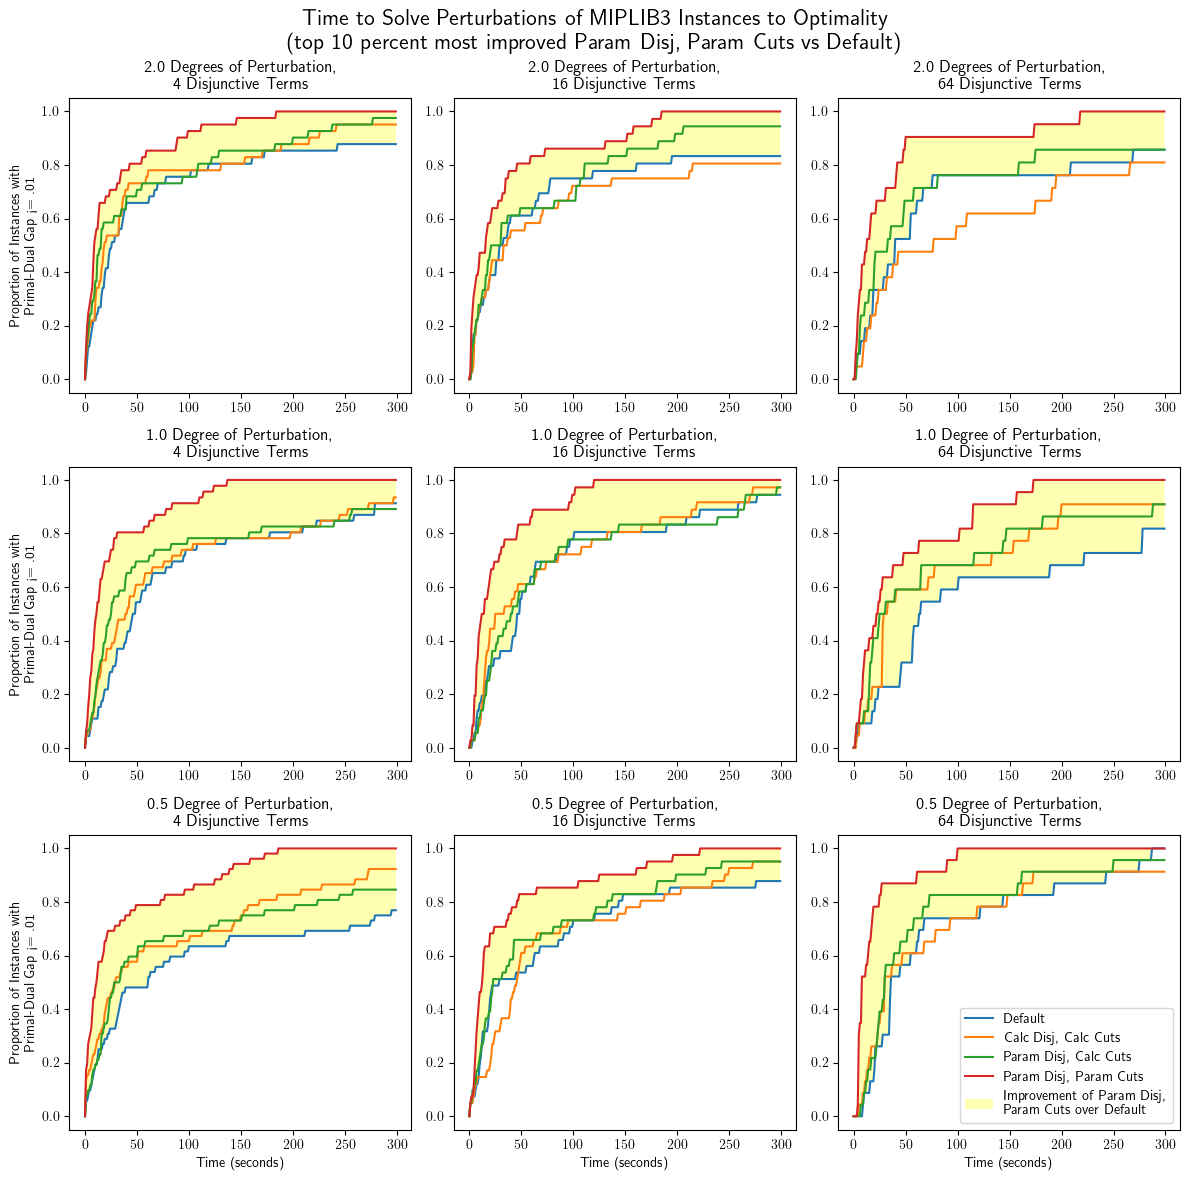

In [52]:
make_plots(time_df, "terminationTime", show_all=True, threshold=.1)

## Improvement Consistency

In [53]:
time_df[["instance", "degree", "terms", "terminationTimeImprovement"]].groupby(["degree", "terms"])

,instance,perturbation,degree,terms,instanceIndex,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,...,rootDualBoundTimeSansVpc Farkas,rootDualBoundTimeSansVpc None,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement
1,mod008,rhs,2.0,64,1,300.132353,300.156200,300.161909,289.457249,278.048,...,2.328,2.265249,275.632,284.676,297.300,287.192,22.084353,13.256200,0.533909,-0.036982
2,mod008,rhs,2.0,64,2,26.187387,19.107139,37.645594,3.521282,7.100,...,2.084,1.821282,4.900,8.460,35.016,1.700,19.087387,8.683139,0.545594,-9.690877
3,mod008,rhs,2.0,64,3,26.231498,19.076552,37.569288,3.513273,7.116,...,2.080,1.825273,4.912,8.440,34.932,1.688,19.115498,8.672552,0.557288,-9.693529
4,mod008,rhs,2.0,64,4,300.138270,300.138952,300.170354,289.297700,278.036,...,2.336,2.285700,275.624,284.744,297.304,287.012,22.102270,13.174952,0.530354,-0.037583
6,fiber,matrix,0.5,16,1,214.119811,300.090145,300.088057,92.387298,205.528,...,6.824,5.043298,200.280,281.904,292.536,87.344,8.591811,10.442145,0.728057,-2.248153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4198,fixnet6,objective,1.0,4,6,183.638493,300.074726,300.066192,300.063510,178.952,...,0.708,0.615510,178.240,297.732,299.240,299.448,4.686493,0.910726,0.118192,-0.000009
4199,fixnet6,objective,1.0,4,7,11.046085,17.797345,2.606449,5.195520,6.116,...,0.712,0.723520,5.216,16.192,1.772,4.472,4.930085,0.933345,0.122449,0.498328
4200,fixnet6,objective,1.0,4,8,244.480909,82.979113,27.245315,135.787540,238.248,...,1.468,1.479540,237.148,79.952,25.656,134.308,6.232909,1.415113,0.121315,0.799353
4201,fixnet6,objective,1.0,4,10,57.188485,157.763396,84.438910,35.187512,51.316,...,0.780,0.855512,49.932,156.164,83.540,34.332,5.872485,0.839396,0.118910,-1.399684


# Make node table

In [48]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,6.447319,6.424992,6.448511,7.547811,-0.000690,37,636
1,0.5,16,9.382808,9.909101,9.753579,9.931278,-0.002463,33,515
2,0.5,64,12.448891,11.396695,12.223123,14.004553,-0.008458,22,302
3,1.0,4,6.198431,6.720040,6.703815,6.922011,-0.000968,40,552
4,1.0,16,11.568443,11.632806,11.885035,12.083138,-0.002670,34,427
5,1.0,64,13.351080,12.907736,13.542288,13.410456,-0.009399,22,250
6,2.0,4,6.777322,6.376581,6.636784,6.115357,-0.001152,40,485
7,2.0,16,9.545973,10.821067,9.531064,11.293685,-0.003022,33,406
8,2.0,64,14.415919,14.044172,13.482774,18.575181,-0.009974,22,221


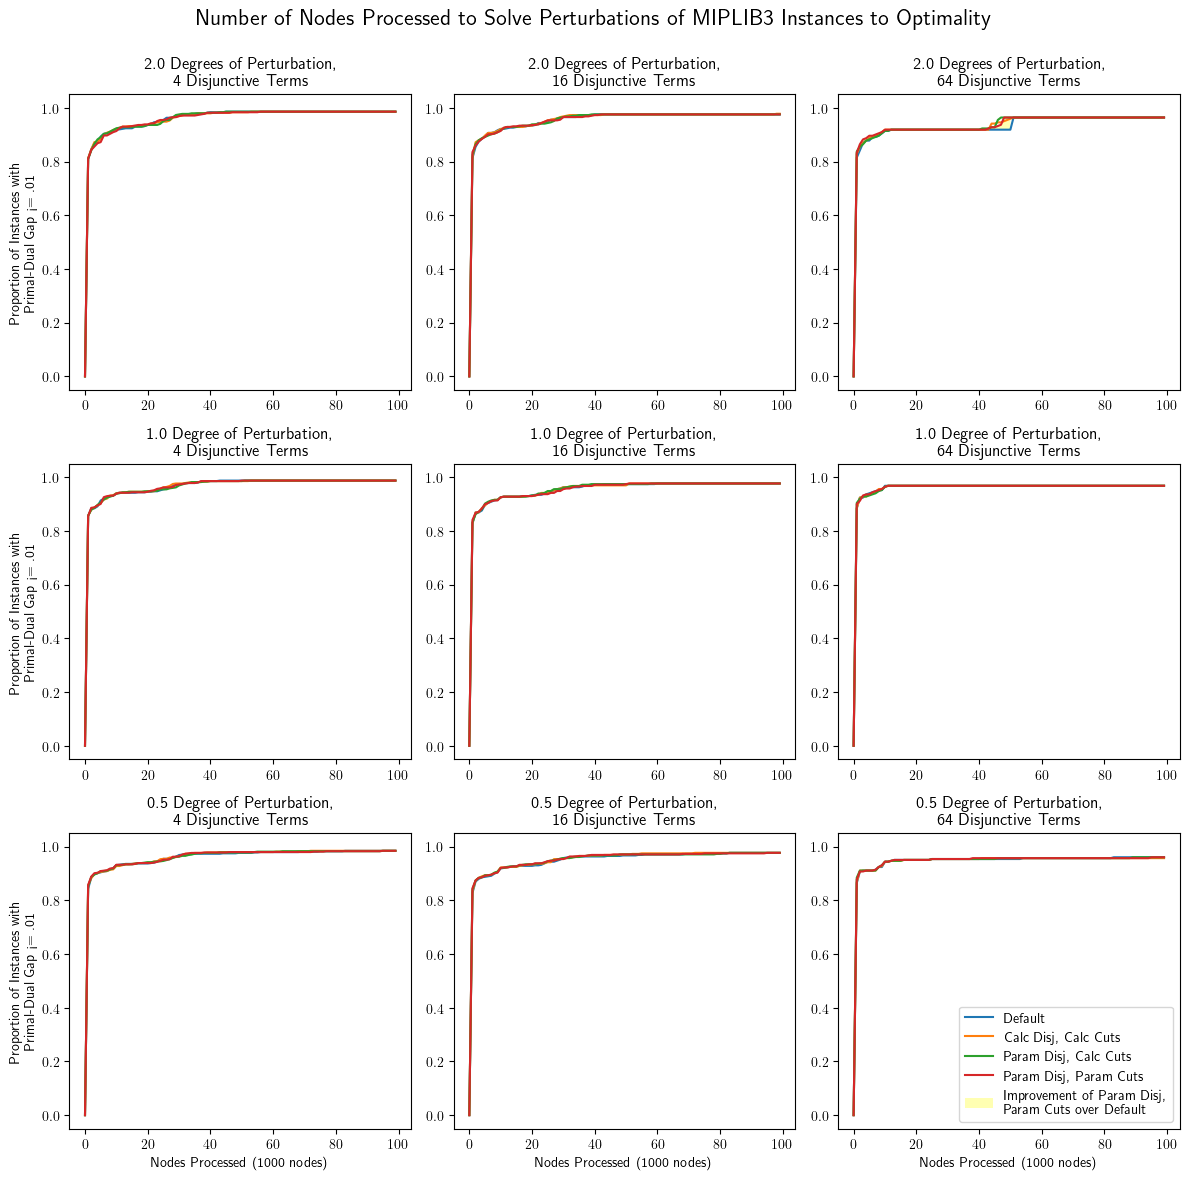

In [49]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [54]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,67.297958,73.088487,73.943056,76.001962,-0.002536,36,520
1,0.5,16,65.960639,69.186171,72.843988,75.118735,-0.001660,30,404
2,0.5,64,74.720570,77.625670,81.129548,90.873602,-0.001627,21,221
3,1.0,4,61.018110,63.240311,63.353465,66.393066,-0.001838,36,456
4,1.0,16,57.434871,60.183459,61.946919,65.447473,-0.000979,30,357
5,1.0,64,62.739869,62.779915,62.285188,75.753338,-0.001602,22,213
6,2.0,4,55.325254,61.485428,65.746526,66.003780,-0.001188,38,409
7,2.0,16,55.599897,52.476986,57.845426,58.520128,-0.000888,32,359
8,2.0,64,68.093873,69.750794,71.062804,78.593039,-0.001416,22,204


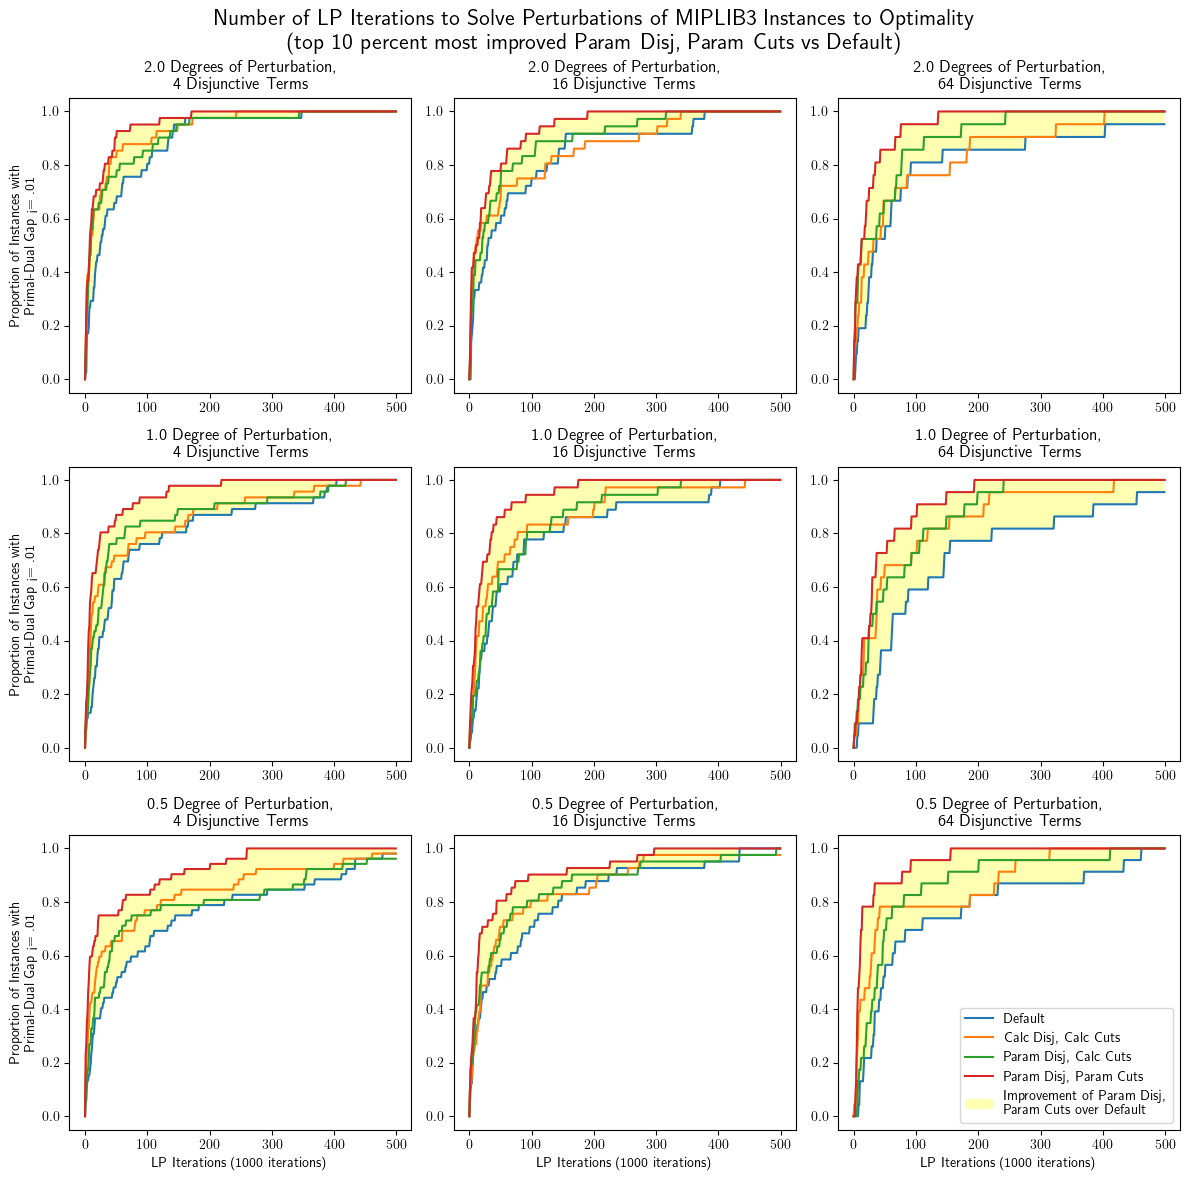

In [55]:
make_plots(iteration_df, "iterations", show_all=True, threshold=.1)